In [1]:
import ee
import os
import random
import geemap
ee.Authenticate()
ee.Initialize(project = 'tony-1122')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
sample = ee.FeatureCollection('projects/tony-1122/assets/TTU/cotton/cotton_dataset_balance')
sample = ee.data.computeFeatures({
    'expression': sample,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [11]:
df = sample.iloc[:, 1:-1]
df.head()

,EVI,EVI_p20,EVI_p80,IBI,IBI_p20,IBI_p20_1,ND_blue_green,ND_blue_nir,ND_blue_p20_green_p20,ND_blue_p20_nir_p20,...,red_p80,seasonality,slope,swir1,swir1_p20,swir1_p80,swir2,swir2_p20,swir2_p80,transition
0,0.502492,0.602376,0.687418,0.074117,0.022132,0.022132,-0.041583,-0.261017,-0.046311,-0.224607,...,1.109314,0,2,1.9763,1.398000,1.897380,1.48705,1.090717,1.487333,10
1,0.741118,0.660443,0.676341,-0.008686,0.008613,0.008613,-0.029739,-0.258167,-0.051012,-0.240535,...,1.130400,0,6,1.4843,1.403450,1.904200,1.16550,1.103500,1.505667,10
2,0.514058,0.621734,0.691443,0.072008,0.023714,0.023714,-0.049119,-0.242505,-0.049895,-0.236176,...,1.125150,0,8,1.8066,1.446517,1.892675,1.52975,1.122700,1.494875,10
3,0.754902,0.619685,0.682292,0.016486,0.017687,0.017687,-0.038568,-0.244752,-0.052296,-0.236346,...,1.126650,1,7,1.5525,1.423200,1.903100,1.12830,1.115000,1.505100,5
4,0.462925,0.619685,0.682292,0.083867,0.017687,0.017687,-0.042501,-0.257184,-0.052296,-0.236346,...,1.126650,1,7,2.0097,1.423200,1.903100,1.54375,1.115000,1.505100,5


##**1DCNN**

In [61]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load your dataset
df = sample.iloc[:, 1:-1]  # Replace with actual file path if needed

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Convert target variable to binary (ensure it's 0 or 1)
y = np.where(y > 0, 1, 0)  # Modify if necessary based on data

# Train-test split (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data to fit 1D CNN + LSTM input format (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# Fully Connected Layers
flatten = Flatten()(cnn)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predictions
y_pred_prob = model.predict(X_val)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
mcc = matthews_corrcoef(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6957 - loss: 0.6188 - val_accuracy: 0.7563 - val_loss: 0.5196
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7891 - loss: 0.4457 - val_accuracy: 0.8148 - val_loss: 0.4143
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8218 - loss: 0.3923 - val_accuracy: 0.8319 - val_loss: 0.3803
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8423 - loss: 0.3578 - val_accuracy: 0.8410 - val_loss: 0.3550
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.8544 - loss: 0.3312 - val_accuracy: 0.8485 - val_loss: 0.3392
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.8624 - loss: 0.3037 - val_accuracy: 0.8524 - val_loss: 0.3282
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8672 - loss: 0.2943 - val_accuracy: 0.8599 - val_loss: 0.3276
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8781 - loss: 0.2743 - val_accu

In [62]:
for layer in model.layers:
    print(layer.name)

input_layer_19
conv1d_37
batch_normalization_22
max_pooling1d_37
conv1d_38
batch_normalization_23
max_pooling1d_38
flatten_15
dense_35
dropout_15
dense_36


121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


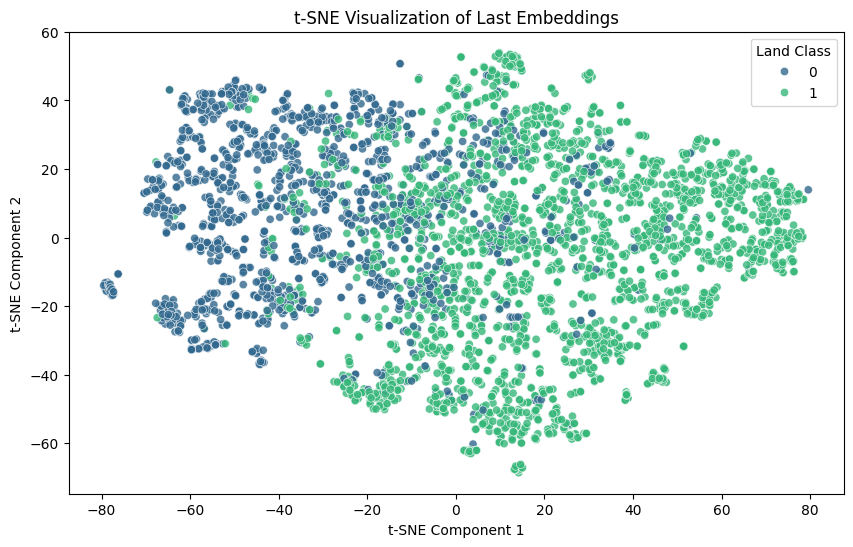

In [63]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output (correct layer name)
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_35').output)

# Get embeddings for X_val
X_embeddings = embedding_layer.predict(X_val)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_val, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


##**1DCNN + LSTM**

In [54]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, matthews_corrcoef

# Load your dataset
df = sample.iloc[:, 1:-1]  # Replace with actual file path if needed

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Convert target variable to binary (ensure it's 0 or 1)
y = np.where(y > 0, 1, 0)  # Modify if necessary based on data

# Train-test split (70% training, 30% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Reshape data to fit 1D CNN + LSTM input format (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM Layers
lstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Fully Connected Layers
flatten = Flatten()(lstm)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predictions
y_pred_prob = model.predict(X_val)  # Probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary predictions

# Evaluation Metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
mcc = matthews_corrcoef(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.7062 - loss: 0.5647 - val_accuracy: 0.6630 - val_loss: 0.6054
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.7920 - loss: 0.4435 - val_accuracy: 0.8135 - val_loss: 0.4075
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.8321 - loss: 0.3719 - val_accuracy: 0.8337 - val_loss: 0.3589
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.8575 - loss: 0.3182 - val_accuracy: 0.8420 - val_loss: 0.3456
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8834 - loss: 0.2728 - val_accuracy: 0.8456 - val_loss: 0.3290
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8937 - loss: 0.2433 - val_accuracy: 0.8648 - val_loss: 0.2974
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9068 - loss: 0.2168 - val_accuracy: 0.8651 - val_loss: 0.3158
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9183 - loss: 0.1827 - 

In [55]:
for layer in model.layers:
    print(layer.name)

input_layer_17
conv1d_33
batch_normalization_20
max_pooling1d_33
conv1d_34
batch_normalization_21
max_pooling1d_34
bidirectional_5
flatten_13
dense_31
dropout_13
dense_32


121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


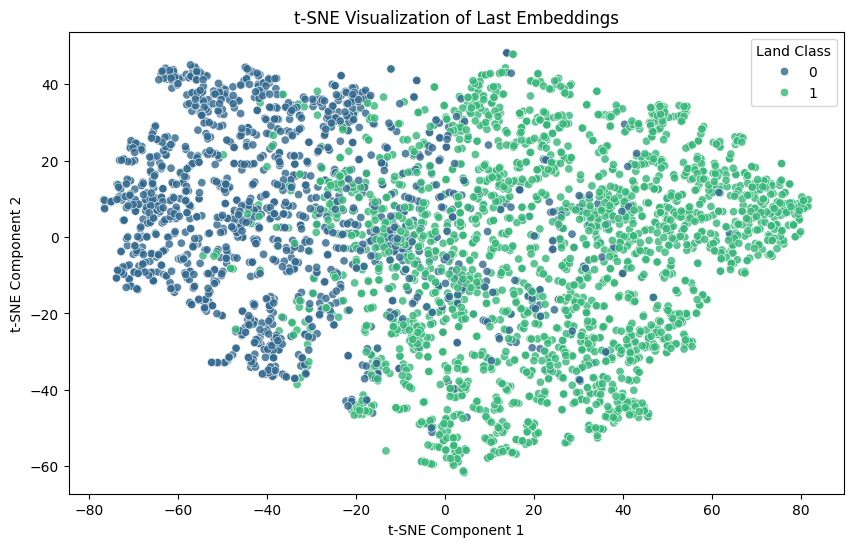

In [57]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output (correct layer name)
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_31').output)

# Get embeddings for X_val
X_embeddings = embedding_layer.predict(X_val)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_val, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


##**1DCNN + LSTM Attention**

In [37]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Bidirectional, Multiply, Permute, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Load and preprocess data
df = sample.iloc[:, 1:-1]  # Adjust column selection as per your dataset

# Define features (X) and target (y)
feature_cols = [col for col in df.columns if col != 'land_class']
X = df[feature_cols].values  # Convert features to NumPy array
y = df['land_class'].values  # Binary target

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Check shape before reshaping
num_samples, num_features = X.shape
print(f"Original shape of X: {X.shape}")

# Determine the closest valid time_steps
time_steps = 10  # You may adjust this value based on the dataset
n_features = num_features // time_steps  # Ensure it divides evenly

if num_features % time_steps != 0:
    print(f"Warning: num_features ({num_features}) is not divisible by time_steps ({time_steps}). Adjusting...")
    n_features = num_features // time_steps  # Reduce to the closest valid value
    X = X[:, :n_features * time_steps]  # Trim excess columns

# Reshape X to (samples, time_steps, features)
X = X.reshape(-1, time_steps, n_features)
print(f"Reshaped X: {X.shape}")

# Convert y to categorical (for binary classification)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Attention Mechanism
def attention_layer(inputs):
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    attention = Multiply()([inputs, attention])  # Apply attention weights
    return attention

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, LSTM, Dense, Dropout, Flatten, Bidirectional, Multiply

# Define the Attention Mechanism
def attention_layer(inputs):
    attention = Dense(inputs.shape[-1], activation='softmax')(inputs)
    attention = Multiply()([inputs, attention])
    return attention

# Define Model
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))  # (time_steps, features)

# CNN Layers
cnn = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

cnn = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)

# LSTM Layers
lstm = Bidirectional(LSTM(64, return_sequences=True))(cnn)

# Attention Mechanism
attention = attention_layer(lstm)

# Fully Connected Layers
flatten = Flatten()(attention)
dense1 = Dense(64, activation='relu')(flatten)
dropout = Dropout(0.3)(dense1)
output = Dense(1, activation='sigmoid')(dropout)  # Binary Classification

# Compile Model
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print Model Summary
model.summary()

# Train Model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
y_pred = (model.predict(X_test) > 0.5).astype(int)
# print("Classification Report:\n", classification_report(y_test, y_pred))
# print("Accuracy:", accuracy_score(y_test, y_pred))

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print Results
print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)


Original shape of X: (12870, 83)
Reshaped X: (12870, 10, 8)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 10, 8)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_29 (Conv1D)        │ (None, 10, 64)         │          1,600 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 10, 64)         │            256 │ conv1d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_29          │ (None, 5, 64)          │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_30 (Conv1D)        │ (None, 5, 32)          │          6,176 │ max_pooling1d_29[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 5, 32)          │            128 │ conv1d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_30          │ (None, 2, 32)          │              0 │ batch_normalization_1… │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 2, 128)         │         49,664 │ max_pooling1d_30[0][0] │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 2, 128)         │         16,512 │ bidirectional_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_8 (Multiply)     │ (None, 2, 128)         │              0 │ bidirectional_4[0][0], │
│                           │                        │                │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_11 (Flatten)      │ (None, 256)            │              0 │ multiply_8[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 64)             │         16,448 │ flatten_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ dense_27[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 1)              │             65 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 90,849 (354.88 KB)

 Trainable params: 90,657 (354.13 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6726 - loss: 0.6034 - val_accuracy: 0.7999 - val_loss: 0.4514
Epoch 2/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8145 - loss: 0.4119 - val_accuracy: 0.8081 - val_loss: 0.4056
Epoch 3/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8334 - loss: 0.3562 - val_accuracy: 0.8326 - val_loss: 0.3672
Epoch 4/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8542 - loss: 0.3207 - val_accuracy: 0.8399 - val_loss: 0.3639
Epoch 5/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8645 - loss: 0.2968 - val_accuracy: 0.8582 - val_loss: 0.3306
Epoch 6/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8744 - loss: 0.2686 - val_accuracy: 0.8679 - val_loss: 0.3135
Epoch 7/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8805 - loss: 0.2449 - val_accuracy: 0.8434 - val_loss: 0.3359
Epoch 8/30
322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8923 - loss: 0.2320 - val_acc

✅ Extracts embeddings from the last Dense layer.

✅ Applies t-SNE for dimensionality reduction.

✅ Plots results with colors indicating land classes.

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


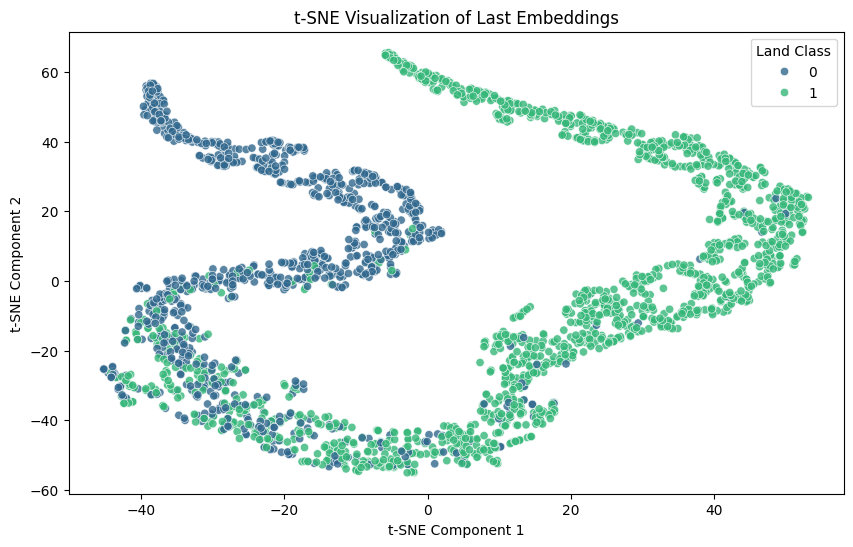

In [41]:
from tensorflow.keras.models import Model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Extract embeddings from the last Dense layer before the output
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_27').output)  # Using 'dense_27'

# Get embeddings for X_test
X_embeddings = embedding_layer.predict(X_test)

# Apply t-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_embeddings)

# Plot t-SNE results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_test, palette='viridis', alpha=0.8)
plt.title("t-SNE Visualization of Last Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Land Class")
plt.show()


81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step
Explained Variance: PC1 = 82.87%, PC2 = 16.37%


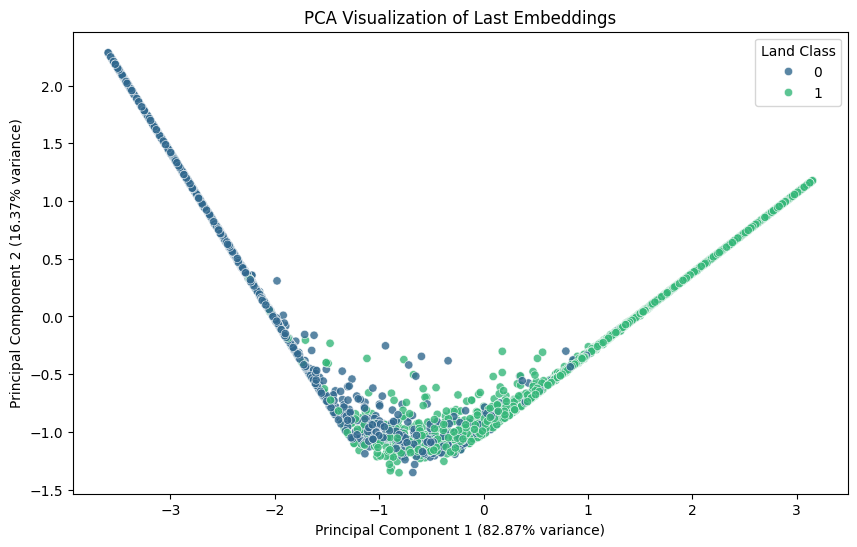

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model

# Extract embeddings from 'dense_27' layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('dense_27').output)
X_embeddings = embedding_layer.predict(X_test)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_embeddings)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance: PC1 = {explained_variance[0]*100:.2f}%, PC2 = {explained_variance[1]*100:.2f}%")

# Plot PCA results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_test, palette='viridis', alpha=0.8)
plt.title("PCA Visualization of Last Embeddings")
plt.xlabel(f"Principal Component 1 ({explained_variance[0]*100:.2f}% variance)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]*100:.2f}% variance)")
plt.legend(title="Land Class")
plt.show()
